In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
import torch
import timm
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
from math import ceil
from tqdm.notebook import tqdm
import wandb
from torch_lr_finder import LRFinder
from utils import EarlyStopping
import utils
import plotly.express as px

In [2]:
from scipy import ndimage

In [3]:
run = wandb.init(project='HyperView-initial', reinit=True)
# wandb.init(mode="disabled") # in case of testing code

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jcharyton (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


### Paths definition

In [4]:
train_data_directory = r'train_data'
test_data_directory = r'test_data'
saved_models_directory = r'saved_models'
submissions_directory = r'submissions'

### Dataset testing

In [5]:
all_files = np.array(
    sorted(
        glob(os.path.join(train_data_directory, 'train_data', "*.npz")),
        key=lambda x: int(os.path.basename(x).replace(".npz", "")),
    )
)

In [6]:
all_files

array(['train_data/train_data/0.npz', 'train_data/train_data/1.npz',
       'train_data/train_data/2.npz', ...,
       'train_data/train_data/1729.npz', 'train_data/train_data/1730.npz',
       'train_data/train_data/1731.npz'], dtype='<U30')

In [7]:
arr = np.ma.MaskedArray(**np.load(all_files[2]))
arr.shape

(150, 11, 11)

In [8]:
arr.mask[0].shape

(11, 11)

In [9]:
arr.mask[0]

array([[ True,  True,  True,  True, False, False, False, False,  True,
         True,  True],
       [ True,  True,  True, False, False, False, False, False, False,
         True,  True],
       [ True,  True, False, False, False, False, False, False, False,
        False,  True],
       [ True, False, False, False, False, False, False, False, False,
        False, False],
       [ True, False, False, False, False, False, False, False, False,
        False, False],
       [ True, False, False, False, False, False, False, False, False,
        False, False],
       [ True, False, False, False, False, False, False, False, False,
        False, False],
       [ True,  True, False, False, False, False, False, False, False,
        False,  True],
       [ True,  True, False, False, False, False, False, False, False,
        False,  True],
       [ True,  True,  True,  True, False, False, False, False,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  Tr

In [10]:
xcenter, ycenter = ndimage.center_of_mass(arr.mask[0])
xcenter = round(xcenter)
ycenter = round(ycenter)
xcenter, ycenter

(6, 4)

In [11]:
arr.mask[0].shape

(11, 11)

In [12]:
arr.mask[0][xcenter-3:xcenter+3, ycenter-3:ycenter+3].shape

(6, 6)

In [13]:
arr.shape[1], arr.shape[2]

(11, 11)

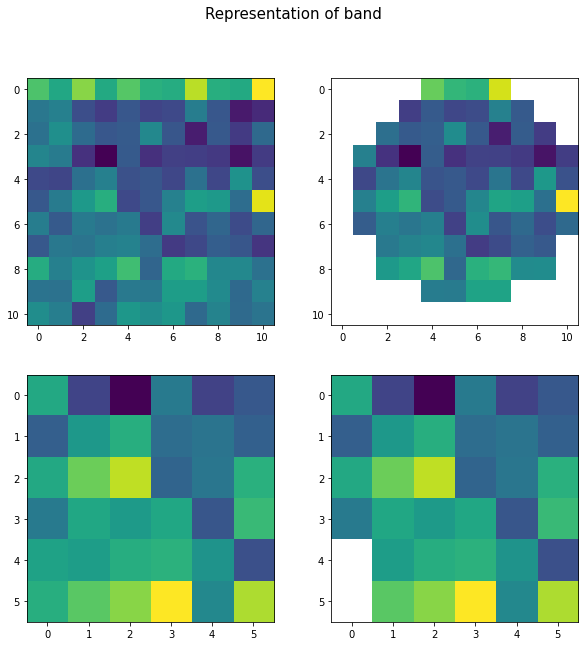

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
band_id = 145

axs[0, 0].imshow(arr[band_id, :, :].data)
axs[0, 1].imshow(arr[band_id, :, :])

axs[1, 0].imshow(arr[band_id, xcenter-3:xcenter+3, ycenter-3:ycenter+3].data)
axs[1, 1].imshow(arr[band_id, xcenter-3:xcenter+3, ycenter-3:ycenter+3])
plt.suptitle(f'Representation of band', fontsize=15)
plt.show()

In [15]:
tensor_data = torch.as_tensor(arr)
tensor_data

tensor([[[ 415,  417,  426,  ...,  449,  437,  469],
         [ 400,  404,  412,  ...,  431,  422,  417],
         [ 413,  423,  403,  ...,  419,  421,  444],
         ...,
         [ 427,  434,  422,  ...,  429,  428,  446],
         [ 414,  430,  441,  ...,  467,  440,  440],
         [ 430,  417,  427,  ...,  438,  444,  420]],

        [[ 405,  416,  427,  ...,  448,  437,  471],
         [ 411,  412,  409,  ...,  425,  422,  424],
         [ 412,  422,  394,  ...,  417,  410,  440],
         ...,
         [ 423,  428,  417,  ...,  423,  423,  440],
         [ 418,  431,  432,  ...,  453,  435,  437],
         [ 427,  415,  419,  ...,  433,  434,  426]],

        [[ 402,  421,  416,  ...,  448,  439,  467],
         [ 408,  399,  401,  ...,  422,  418,  421],
         [ 406,  409,  389,  ...,  413,  408,  424],
         ...,
         [ 414,  420,  413,  ...,  415,  424,  433],
         [ 409,  423,  427,  ...,  441,  428,  428],
         [ 420,  418,  409,  ...,  433,  427,  428]],

In [16]:
tensor_data.shape

torch.Size([150, 11, 11])

In [17]:
tensor_mask_bool = ~torch.as_tensor(arr.mask)
tensor_mask_bool

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ...,  True, False, False],
         [False, False,  True,  ...,  True,  True, False],
         ...,
         [False, False,  True,  ...,  True,  True, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ...,  True, False, False],
         [False, False,  True,  ...,  True,  True, False],
         ...,
         [False, False,  True,  ...,  True,  True, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ...,  True, False, False],
         [False, False,  True,  ...,  True,  True, False],
         ...,
         [False, False,  True,  ...,  True,  True, False],
         [

In [18]:
tensor_mask_bool_array = tensor_mask_bool.cpu().numpy()

In [19]:
tensor_mask_bool.shape

torch.Size([150, 11, 11])

In [20]:
tensor_data_masked = torch.mul(tensor_data, tensor_mask_bool)
tensor_data_masked

tensor([[[   0,    0,    0,  ...,    0,    0,    0],
         [   0,    0,    0,  ...,  431,    0,    0],
         [   0,    0,  403,  ...,  419,  421,    0],
         ...,
         [   0,    0,  422,  ...,  429,  428,    0],
         [   0,    0,    0,  ...,    0,    0,    0],
         [   0,    0,    0,  ...,    0,    0,    0]],

        [[   0,    0,    0,  ...,    0,    0,    0],
         [   0,    0,    0,  ...,  425,    0,    0],
         [   0,    0,  394,  ...,  417,  410,    0],
         ...,
         [   0,    0,  417,  ...,  423,  423,    0],
         [   0,    0,    0,  ...,    0,    0,    0],
         [   0,    0,    0,  ...,    0,    0,    0]],

        [[   0,    0,    0,  ...,    0,    0,    0],
         [   0,    0,    0,  ...,  422,    0,    0],
         [   0,    0,  389,  ...,  413,  408,    0],
         ...,
         [   0,    0,  413,  ...,  415,  424,    0],
         [   0,    0,    0,  ...,    0,    0,    0],
         [   0,    0,    0,  ...,    0,    0,    0]],

In [21]:
tensor_data_masked_array = tensor_data_masked.cpu().numpy()

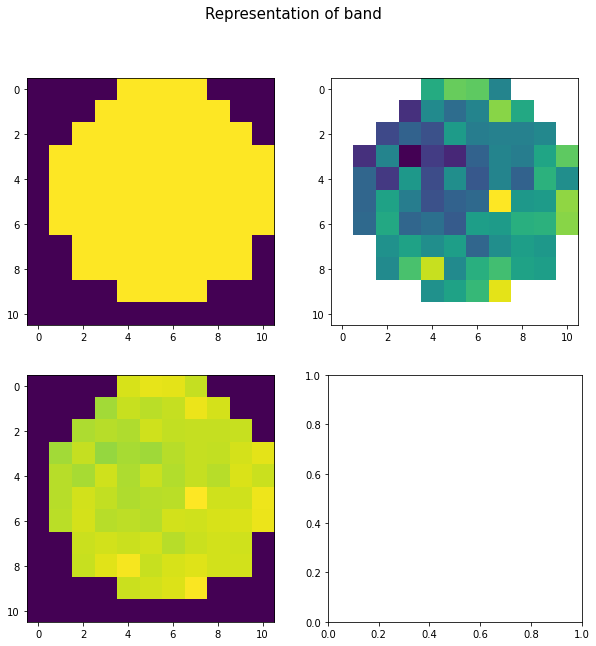

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].imshow(tensor_mask_bool_array[0, :, :].data)
axs[0, 1].imshow(arr[0, :, :])

axs[1, 0].imshow(tensor_data_masked_array[0, :, :])
plt.suptitle(f'Representation of band', fontsize=15)
plt.show()

In [23]:
tensor_data_masked.shape

torch.Size([150, 11, 11])

In [5]:
def pad_to_minimum_size(min_size, image):
    c, h, w = image.shape
    h_diff = (min_size - h)/2
    w_diff = (min_size - w)/2
    print(h_diff, w_diff)

    if not h_diff.is_integer():
        h_pad1 = int(h_diff - 0.5)
        h_pad2 = int(h_diff + 0.5)
    else:
        h_pad1 = h_pad2 = int(h_diff)

    if not w_diff.is_integer():
        w_pad1 = int(w_diff - 0.5)
        w_pad2 = int(w_diff + 0.5)
    else:
        w_pad1 = w_pad2 = int(w_diff)

    print(h_pad1, h_pad2, w_pad1, w_pad2)
    # check if any padding is bigger than zero
    if h_pad1+h_pad2+w_pad1+h_pad2 == 0:
        return image
    else:
        return transforms.functional.pad(image, (w_pad1, h_pad1, w_pad2, h_pad2), fill=0)

In [25]:
pad_to_minimum_size(300, tensor_data_masked).shape

144.5 144.5
144 145 144 145


torch.Size([150, 300, 300])

In [26]:
tensor_mask_bool[0]

tensor([[False, False, False, False,  True,  True,  True,  True, False, False,
         False],
        [False, False, False,  True,  True,  True,  True,  True,  True, False,
         False],
        [False, False,  True,  True,  True,  True,  True,  True,  True,  True,
         False],
        [False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [False, False,  True,  True,  True,  True,  True,  True,  True,  True,
         False],
        [False, False,  True,  True,  True,  True,  True,  True,  True,  True,
         False],
        [False, False, False, False,  True,  True,  True,  True, False, False,
         False],
        [False, False, False, False, Fal

In [27]:
padded_mask = pad_to_minimum_size(300, tensor_mask_bool)
padded_mask.shape

144.5 144.5
144 145 144 145


torch.Size([150, 300, 300])

In [28]:
xcenter, ycenter = ndimage.center_of_mass(padded_mask.cpu().numpy()[0])
xcenter = round(xcenter)
ycenter = round(ycenter)
xcenter, ycenter

(149, 150)

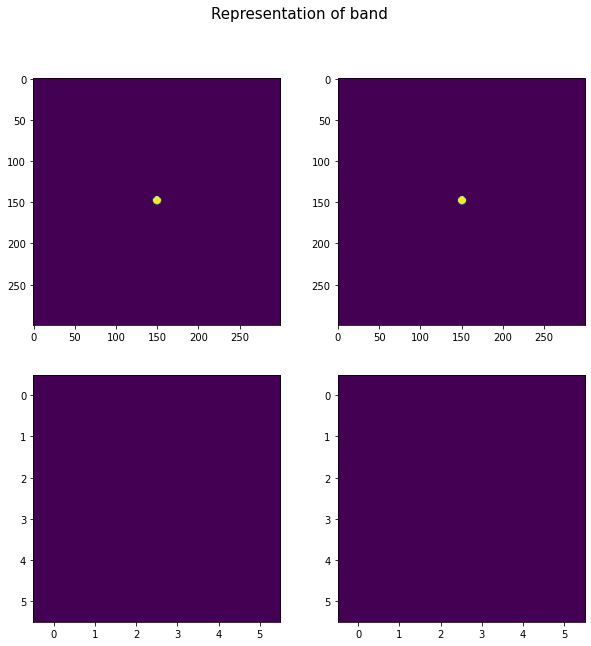

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].imshow(padded_mask.cpu().numpy()[0, :, :].data)
axs[0, 1].imshow(padded_mask.cpu().numpy()[0, :, :])

axs[1, 0].imshow(padded_mask.cpu().numpy()[0, xcenter -
                 3:xcenter+3, ycenter-3:ycenter+3].data)
axs[1, 1].imshow(padded_mask.cpu().numpy()[
                 0, xcenter-3:xcenter+3, ycenter-3:ycenter+3])
plt.suptitle(f'Representation of band', fontsize=15)
plt.show()

In [30]:
padded_mask.cpu().numpy()[0, xcenter-3:xcenter+3, ycenter-3:ycenter+3]

array([[ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True]])

### Load mean and std values of training dataset

In [5]:
means_stds_arrays = np.load(os.path.join(
    train_data_directory, 'means_stds_values_training_data.npz'))
means = np.array(means_stds_arrays['means'])
stds = np.array(means_stds_arrays['stds'])

In [7]:
tensor_data_masked_normalized = transforms.functional.normalize(torch.as_tensor(
    tensor_data_masked, dtype=torch.float), mean=means.tolist(), std=stds.tolist())
tensor_data_masked_normalized

NameError: name 'tensor_data_masked' is not defined

In [10]:
temp_gt = pd.read_csv(os.path.join(train_data_directory, 'train_gt.csv'))[
    ['sample_index', 'P', 'K', 'Mg', 'pH']]

In [11]:
temp_gt

,sample_index,P,K,Mg,pH
0,0,45.1,188.0,179.0,7.2
1,1,44.8,205.0,188.0,7.0
2,2,44.4,207.0,145.0,6.8
3,3,46.5,204.0,143.0,6.8
4,4,52.0,212.0,167.0,6.7
...,...,...,...,...,...
1727,1727,40.8,133.0,132.0,6.2
1728,1728,42.7,192.0,126.0,6.5
1729,1729,39.4,180.0,122.0,6.5
1730,1730,37.3,162.0,127.0,6.5


In [12]:
temp_gt.loc[1, 'P']

44.8

### Dataset definition

In [6]:
class HyperViewDataset(Dataset):
    def __init__(self, gt_file, img_dir, transform=True, means=None, stds=None, train_transforms=False):
        self.img_dir = img_dir
        if gt_file is not None:
            self.gt = pd.read_csv(gt_file)[['sample_index', 'P', 'K', 'Mg', 'pH']]
        else:
            self.gt = None
        self.transform = transform  # whether to perform transformation of input data
        # whether to perform transformations like on training data
        self.train_transforms = train_transforms

        if self.train_transforms:
            self.training_transforms_composition = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.4), transforms.RandomVerticalFlip(p=0.4)])

        self.means = means  # mean values for every band used to normalize data
        self.stds = stds  # std values for every band used to normalize data

        self.img_files = np.array(
            sorted(
                glob(os.path.join(img_dir, "*.npz")),
                key=lambda x: int(os.path.basename(x).replace(".npz", "")),
            )
        )

    def pad_to_minimum_size(self, min_size, image):
        # pads numpy array to defined in `min_size` minimum size of array (w, h)
        c, h, w = image.shape
        h_diff = (min_size - h)/2
        w_diff = (min_size - w)/2

        if not h_diff.is_integer():
            h_pad1 = int(h_diff - 0.5)
            h_pad2 = int(h_diff + 0.5)
        else:
            h_pad1 = h_pad2 = int(h_diff)

        if not w_diff.is_integer():
            w_pad1 = int(w_diff - 0.5)
            w_pad2 = int(w_diff + 0.5)
        else:
            w_pad1 = w_pad2 = int(w_diff)

        # check if any padding is bigger than zero
        if h_pad1+h_pad2+w_pad1+h_pad2 == 0:
            return image
        else:
            return transforms.functional.pad(image, (w_pad1, h_pad1, w_pad2, h_pad2), fill=0)

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        # load hyperspectral image to array
        img_arr = np.ma.MaskedArray(**np.load(self.img_files[idx]))
        img_tensor = torch.as_tensor(img_arr.data, dtype=torch.float)
        # Inverting mask is necessary due to masking method in numpy
        img_tensor_mask = ~torch.as_tensor(img_arr.mask)
        img_masked_tensor = torch.mul(img_tensor, img_tensor_mask)

        if self.transform:
            img_masked_tensor_transformed = transforms.functional.normalize(
                img_masked_tensor, mean=self.means.tolist(), std=self.stds.tolist())
            img_masked_tensor_transformed = self.pad_to_minimum_size(
                300, img_masked_tensor_transformed)
            if self.train_transforms:
                img_masked_tensor_transformed = self.training_transforms_composition(
                    img_masked_tensor_transformed)
            img_result_tensor = img_masked_tensor_transformed
        else:
            img_result_tensor = img_masked_tensor
        # load labels
        if self.gt is not None:
            P_gt = self.gt.loc[idx, 'P']
            K_gt = self.gt.loc[idx, 'K']
            Mg_gt = self.gt.loc[idx, 'Mg']
            pH_gt = self.gt.loc[idx, 'pH']
            sample_index = self.gt.loc[idx, 'sample_index']

            sample = {'image': img_result_tensor, 'P': P_gt,
                      'K': K_gt, 'Mg': Mg_gt, 'pH': pH_gt, 'sample_index': sample_index}
        else:
            sample = {'image': img_result_tensor}

        return sample

In [7]:
train_data_whole = HyperViewDataset(os.path.join(train_data_directory, 'train_gt.csv'), os.path.join(
    train_data_directory, 'train_data'), True, means, stds, train_transforms=True)

In [8]:
train_dataset, validation_dataset = random_split(train_data_whole, [1400, 332], generator=torch.Generator().manual_seed(22))
# train_dataset = torch.utils.data.Subset(train_data_whole, list(range(0, 1400)))
# validation_dataset = torch.utils.data.Subset(train_data_whole, list(range(1400, len(train_data_whole))))

### Model Definition

In [9]:
import torchvision
from torchvision import datasets, models, transforms

In [10]:
class ResNetCNN(nn.Module):
    def __init__(self, pretrained):
        super().__init__()
        self.resnet_model = models.resnet50(pretrained=False)

        self.resnet_model.conv1 = nn.Conv2d(150, 64, kernel_size=(
            7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.resnet_model.fc = nn.Linear(
            in_features=2048, out_features=4, bias=True)

    def forward(self, x):
        x = self.resnet_model(x)
#         return {'P': x[0], 'K': x[1], 'Mg': x[2], 'pH': x[3]}
        return x

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [12]:
BATCH_SIZE = 12
EPOCHS = 300

In [13]:
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, pin_memory=True, drop_last=True, num_workers=4, shuffle=True)
validation_dataloader = DataLoader(
    validation_dataset, batch_size=BATCH_SIZE, pin_memory=True, drop_last=True, num_workers=4, shuffle=True)

### Overfitting on single batch of data

In [14]:
model = ResNetCNN(pretrained=False)
model.to(device)

ResNetCNN(
  (resnet_model): ResNet(
    (conv1): Conv2d(150, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

In [196]:
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

In [197]:
train_data_single_batch = next(iter(train_dataloader))

In [52]:
train_data_single_batch

{'image': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          ...,
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...

In [198]:
train_data_single_batch['image'][0].shape

torch.Size([150, 300, 300])

In [199]:
train_data_single_batch['image'].to(device, dtype=torch.float).shape

torch.Size([12, 150, 300, 300])

In [200]:
output = model(train_data_single_batch['image'].to(device, dtype=torch.float))

In [201]:
output

tensor([[-0.4664, -0.2055,  0.3345, -1.5900],
        [-0.2442,  0.0653,  0.2953, -1.4492],
        [-0.0528, -0.0550,  0.1245, -0.1731],
        [-0.2713, -0.0392,  0.3000, -1.2935],
        [-0.3082,  0.0754,  0.2444, -0.9583],
        [-0.1899, -0.0305,  0.1322, -0.4086],
        [-0.1597, -0.0359,  0.1535, -0.2933],
        [-0.0522, -0.0395,  0.1124, -0.1884],
        [-0.3373,  0.0148,  0.3089, -0.9856],
        [-0.3547, -0.2934,  0.3404, -1.4583],
        [-0.1024,  0.0166,  0.1095, -0.3071],
        [-0.0861, -0.0361,  0.1426, -0.1916]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [202]:
stacked_gt = torch.stack((train_data_single_batch['P'], train_data_single_batch['K'],
                         train_data_single_batch['Mg'], train_data_single_batch['pH']))
stacked_gt

tensor([[ 57.2000, 208.0000,  48.5000,  51.2000, 104.0000, 141.0000,  74.1000,
          42.9000,  47.0000,  75.8000,  35.0000,  27.6000],
        [244.0000, 292.0000, 235.0000, 190.0000, 351.0000, 437.0000, 186.0000,
         218.0000, 176.0000, 180.0000, 169.0000, 233.0000],
        [160.0000, 208.0000, 133.0000, 188.0000, 146.0000, 141.0000, 130.0000,
         112.0000, 170.0000, 148.0000, 142.0000, 250.0000],
        [  6.6000,   6.6000,   7.1600,   6.7000,   6.7000,   7.2000,   6.7000,
           6.9700,   6.9000,   6.8000,   7.0000,   6.5800]],
       dtype=torch.float64)

In [203]:
stacked_gt = stacked_gt.transpose(0, 1).to(device)
stacked_gt

tensor([[ 57.2000, 244.0000, 160.0000,   6.6000],
        [208.0000, 292.0000, 208.0000,   6.6000],
        [ 48.5000, 235.0000, 133.0000,   7.1600],
        [ 51.2000, 190.0000, 188.0000,   6.7000],
        [104.0000, 351.0000, 146.0000,   6.7000],
        [141.0000, 437.0000, 141.0000,   7.2000],
        [ 74.1000, 186.0000, 130.0000,   6.7000],
        [ 42.9000, 218.0000, 112.0000,   6.9700],
        [ 47.0000, 176.0000, 170.0000,   6.9000],
        [ 75.8000, 180.0000, 148.0000,   6.8000],
        [ 35.0000, 169.0000, 142.0000,   7.0000],
        [ 27.6000, 233.0000, 250.0000,   6.5800]], device='cuda:0',
       dtype=torch.float64)

In [204]:
loss_func(output, stacked_gt)

tensor(25096.1607, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>)

In [205]:
img_data_device = train_data_single_batch['image'].to(
    device, dtype=torch.float)
stacked_gt_device = torch.stack((train_data_single_batch['P'], train_data_single_batch['K'], train_data_single_batch['Mg'], train_data_single_batch['pH'])).transpose(0, 1).to(device,
                                                                                                                                                                               dtype=torch.float)

model = ResNetCNN(False).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.005)
loss_func = torch.nn.MSELoss()

for epoch in range(301):
    model.train()

    output = model(img_data_device)
    loss = loss_func(output, stacked_gt_device)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    output_cpu = output.detach().cpu().numpy()
    stacked_gt_cpu = stacked_gt_device.cpu().numpy()

    # Calculate MSE for each class
    mse = np.mean((stacked_gt_cpu - output_cpu) ** 2, axis=0)

    if epoch % 10 == 0:
        print(f'epoch: {epoch}, loss: {loss.data.cpu().numpy()}, MSE: {mse}')

epoch: 0, loss: 25049.25, MSE: [8.3881738e+03 6.4772438e+04 2.6999900e+04 3.6478886e+01]
epoch: 10, loss: 2959.900390625, MSE: [2316.6626   7644.844    1860.1621     17.931849]
epoch: 50, loss: 463.47625732421875, MSE: [648.7326     507.7489     696.54         0.88362616]
epoch: 60, loss: 343.34857177734375, MSE: [6.9604865e+02 4.1850992e+02 2.5825461e+02 5.8104426e-01]
epoch: 70, loss: 252.3623504638672, MSE: [6.8544745e+02 1.4383578e+02 1.7975159e+02 4.1455284e-01]
epoch: 80, loss: 90.53755187988281, MSE: [251.21724     60.79799     49.649136     0.48583004]
epoch: 90, loss: 101.4475326538086, MSE: [2.1145128e+02 7.0920326e+01 1.2322817e+02 1.9033308e-01]
epoch: 100, loss: 34.72819519042969, MSE: [40.46098    50.554916   47.801815    0.09506875]
epoch: 110, loss: 28.47444725036621, MSE: [37.168743  62.162693  14.490933   0.0754094]
epoch: 120, loss: 11.710805892944336, MSE: [16.96544    19.652523   10.161715    0.06354145]
epoch: 130, loss: 5.4802703857421875, MSE: [6.6728063  9.3710

### Training

In [15]:
save_name = "checkpoint_state_dict_ResNet50_07_05_2022"

In [16]:
model_name = save_name+'.pth'

In [17]:
# save subsets indices to text files
np.array(train_dataset.indices).tofile(os.path.join(saved_models_directory, 'DataSubsets_indices', save_name+'_train_indices.txt'), sep='|')
np.array(validation_dataset.indices).tofile(os.path.join(saved_models_directory, 'DataSubsets_indices', save_name+'_validation_indices.txt'), sep='|')

In [18]:
model = ResNetCNN(False).to(device)

In [19]:
wandb.watch(model, log="None", log_freq=20)

[]

In [20]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

In [21]:
loss_func = torch.nn.MSELoss()

#### Find LR

In [48]:
from torch_lr_finder.lr_finder import TrainDataLoaderIter

In [49]:
class CustomTrainIter(TrainDataLoaderIter):
    def inputs_labels_from_batch(self, batch_data):
        return (torch.as_tensor(batch_data['image'], dtype=torch.float),
                torch.as_tensor(torch.stack((batch_data['P'], batch_data['K'], batch_data['Mg'], batch_data['pH'])).transpose(0, 1), dtype=torch.float))

In [50]:
lr_finder = LRFinder(model, optimizer, loss_func, device=device)
lr_finder.range_test(CustomTrainIter(train_dataloader),
                     start_lr=0.00001, end_lr=100, num_iter=100)

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 6.73E-03


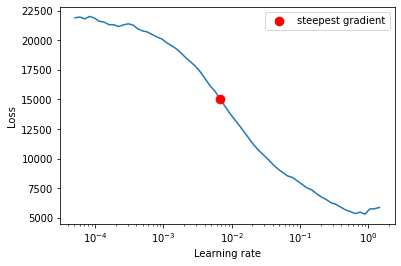

In [51]:
lr_finder.plot()
lr_finder.reset()

In [46]:
6.73E-03

0.00673

#### Continue training

In [22]:
patience_scheduler_overfit = 5
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min',
                                                       factor=0.6, patience=patience_scheduler_overfit,
                                                       threshold=0.0001, threshold_mode='abs')

In [23]:
early_stopping = utils.EarlyStopping(patience=(2*patience_scheduler_overfit)+3, verbose=True,
                                     path=os.path.join(saved_models_directory, 'checkpoint_state_dict.pth'))

In [24]:
config = wandb.config
config.model = 'resnet50'
config.optimizer = 'AdamW'
config.learning_rate_start = optimizer.param_groups[0]["lr"]
# config.momentum = optimizer.param_groups[0]["momentum"]
config.momentum = None
config.weight_decay = optimizer.param_groups[0]["weight_decay"]
config.scheduler = 'ReduceLROnPlateau'
config.scheduler_factor = 0.6
config.scheduler_patience = 5
config.scheduler_threshold = 0.0001
config.batch_size = BATCH_SIZE
config.notes = 'Restarting best model'

In [25]:
previous_epochs = 0  # how many epochs have been done previously if resuming

In [26]:
for epoch in range(previous_epochs, EPOCHS+previous_epochs):
    # TRAINING Part
    model.train()
    train_loss = []
    mse_train_list = []

    bar = tqdm(train_dataloader, position=0, leave=False,
               desc=f'epoch {epoch} training data')
    i = 0
    for train_data in bar:  # for each training step
        i += 1
        img_data_device = train_data['image'].to(device, dtype=torch.float)
        stacked_gt_device = torch.stack((train_data['P'], train_data['K'], train_data['Mg'], train_data['pH'])).transpose(
            0, 1).to(device, dtype=torch.float)

        output = model(img_data_device)

        loss = loss_func(output, stacked_gt_device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss)

        output_cpu = output.detach().cpu().numpy()
        stacked_gt_cpu = stacked_gt_device.cpu().numpy()

        # Calculate MSE for each class
        mse = np.mean((stacked_gt_cpu - output_cpu) ** 2, axis=0)
        mse_train_list.append(mse)

        if i % 10 == 0:  # log every 10 batches
            train_log_dict = dict()
            train_log_dict['batch_number'] = i
            train_log_dict['epoch'] = epoch
            train_log_dict['train_batch_loss'] = loss
            train_log_dict['train_batch_MSE_P'] = mse[0]
            train_log_dict['train_batch_MSE_K'] = mse[1]
            train_log_dict['train_batch_MSE_Mg'] = mse[2]
            train_log_dict['train_batch_MSE_pH'] = mse[3]
            wandb.log(train_log_dict)

    avg_train_loss = torch.stack(train_loss).mean().item()
    avg_train_mse = torch.as_tensor(
        np.array(mse_train_list)).mean(axis=0).numpy().tolist()

    print(
        f'epoch: {epoch}, LR: {optimizer.param_groups[0]["lr"]}, train loss: {avg_train_loss}, train MSE: {avg_train_mse}')
    wandb.log({'epoch': epoch, 'average_train_loss': avg_train_loss, 'average_train_MSE_P': avg_train_mse[0], 'average_train_MSE_K': avg_train_mse[1],
              'average_train_MSE_Mg': avg_train_mse[2], 'average_train_MSE_pH': avg_train_mse[3]})

    # VALIDATION Part
    model.eval()
    val_bar = tqdm(validation_dataloader, position=0,
                   leave=False, desc=f'epoch {epoch} validation data')
    with torch.no_grad():
        val_loss = []
        mse_val_list = []
        for val_data in val_bar:
            img_data_device = val_data['image'].to(device, dtype=torch.float)
            stacked_gt_device = torch.stack((val_data['P'], val_data['K'], val_data['Mg'], val_data['pH'])).transpose(
                0, 1).to(device, dtype=torch.float)

            output = model(img_data_device)

            loss = loss_func(output, stacked_gt_device)
            val_loss.append(loss)

            output_cpu = output.detach().cpu().numpy()
            stacked_gt_cpu = stacked_gt_device.cpu().numpy()

            # Calculate MSE for each class
            mse = np.mean((stacked_gt_cpu - output_cpu) ** 2, axis=0)
            mse_val_list.append(mse)

        avg_val_loss = torch.stack(val_loss).mean().item()
        avg_val_mse = torch.as_tensor(
            np.array(mse_val_list)).mean(axis=0).numpy().tolist()

        print(f'epoch: {epoch}, validation loss: {avg_val_loss}, validation MSE: {avg_val_mse}')
        wandb.log({'epoch': epoch, 'average_val_loss': avg_val_loss, 'average_val_MSE_P': avg_val_mse[0], 'average_val_MSE_K': avg_val_mse[1],
                   'average_val_MSE_Mh': avg_val_mse[2], 'average_val_MSE_pH': avg_val_mse[3]})

        scheduler.step(avg_val_loss)
        # early_stopping needs the validation loss to check if it has decresed,
        # and if it has, it will make a checkpoint of the current model
        early_stopping(avg_val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

epoch 0 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 0, LR: 0.01, train loss: 2242.281005859375, train MSE: [1183.9449462890625, 5485.93310546875, 2287.150146484375, 12.096457481384277]


epoch 0 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 0, validation loss: 1480.076416015625, validation MSE: [822.9300537109375, 3305.822998046875, 1791.4796142578125, 0.07237640768289566]
Validation loss decreased (inf --> 1480.076416).  Saving model ...


epoch 1 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 1, LR: 0.01, train loss: 1712.588623046875, train MSE: [987.874755859375, 4213.18896484375, 1648.919189453125, 0.37118223309516907]


epoch 1 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 1, validation loss: 2982.488525390625, validation MSE: [852.58203125, 6144.67138671875, 4925.861328125, 6.838492393493652]
EarlyStopping counter: 1 out of 13


epoch 2 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 2, LR: 0.01, train loss: 1720.3585205078125, train MSE: [989.7230834960938, 4198.41650390625, 1693.14990234375, 0.14442408084869385]


epoch 2 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 2, validation loss: 1452.3963623046875, validation MSE: [840.604736328125, 3211.156494140625, 1757.7373046875, 0.08682674914598465]
Validation loss decreased (1480.076416 --> 1452.396362).  Saving model ...


epoch 3 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 3, LR: 0.01, train loss: 1712.0439453125, train MSE: [1013.0595092773438, 4172.84619140625, 1662.0872802734375, 0.1822534203529358]


epoch 3 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 3, validation loss: 1487.1767578125, validation MSE: [795.1141357421875, 3374.31884765625, 1779.1229248046875, 0.1508188396692276]
EarlyStopping counter: 1 out of 13


epoch 4 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 4, LR: 0.01, train loss: 1679.3402099609375, train MSE: [969.0289306640625, 4103.8759765625, 1644.26953125, 0.185860738158226]


epoch 4 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 4, validation loss: 1364.417724609375, validation MSE: [747.0888061523438, 3001.94091796875, 1708.5579833984375, 0.08277592062950134]
Validation loss decreased (1452.396362 --> 1364.417725).  Saving model ...


epoch 5 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 5, LR: 0.01, train loss: 1685.849365234375, train MSE: [964.3289794921875, 4125.85400390625, 1653.0562744140625, 0.15826469659805298]


epoch 5 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 5, validation loss: 1471.8599853515625, validation MSE: [914.4652709960938, 3256.908447265625, 1716.00439453125, 0.06125029921531677]
EarlyStopping counter: 1 out of 13


epoch 6 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 6, LR: 0.01, train loss: 1682.4102783203125, train MSE: [980.544189453125, 4083.974365234375, 1664.973876953125, 0.14840325713157654]


epoch 6 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 6, validation loss: 1567.3082275390625, validation MSE: [773.1585693359375, 3761.145751953125, 1734.754638671875, 0.17344188690185547]
EarlyStopping counter: 2 out of 13


epoch 7 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 7, LR: 0.01, train loss: 1648.248291015625, train MSE: [949.6590576171875, 4011.49951171875, 1631.708251953125, 0.12591415643692017]


epoch 7 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 7, validation loss: 1413.9979248046875, validation MSE: [771.8239135742188, 3217.07470703125, 1667.0145263671875, 0.07835603505373001]
EarlyStopping counter: 3 out of 13


epoch 8 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 8, LR: 0.01, train loss: 1656.2855224609375, train MSE: [934.228759765625, 4030.577392578125, 1660.203857421875, 0.13230173289775848]


epoch 8 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 8, validation loss: 1430.3118896484375, validation MSE: [851.2210693359375, 3145.423095703125, 1724.45947265625, 0.14369675517082214]
EarlyStopping counter: 4 out of 13


epoch 9 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 9, LR: 0.01, train loss: 1669.6209716796875, train MSE: [933.6954345703125, 4057.33349609375, 1687.3062744140625, 0.14815673232078552]


epoch 9 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 9, validation loss: 1340.1187744140625, validation MSE: [737.0031127929688, 2883.676025390625, 1739.72216796875, 0.07336197793483734]
Validation loss decreased (1364.417725 --> 1340.118774).  Saving model ...


epoch 10 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 10, LR: 0.01, train loss: 1653.5560302734375, train MSE: [938.8171997070312, 4044.92041015625, 1630.347900390625, 0.1384664624929428]


epoch 10 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 10, validation loss: 1397.4990234375, validation MSE: [780.7199096679688, 3100.144287109375, 1709.0150146484375, 0.11655367910861969]
EarlyStopping counter: 1 out of 13


epoch 11 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 11, LR: 0.01, train loss: 1632.968505859375, train MSE: [919.0573120117188, 3989.10498046875, 1623.568115234375, 0.14296355843544006]


epoch 11 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 11, validation loss: 1587.85400390625, validation MSE: [724.103759765625, 3392.514404296875, 2234.471923828125, 0.32537099719047546]
EarlyStopping counter: 2 out of 13


epoch 12 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 12, LR: 0.01, train loss: 1689.0479736328125, train MSE: [995.1234130859375, 4118.42041015625, 1642.536376953125, 0.11066311597824097]


epoch 12 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 12, validation loss: 1401.72314453125, validation MSE: [727.984130859375, 3183.177734375, 1695.6317138671875, 0.09883726388216019]
EarlyStopping counter: 3 out of 13


epoch 13 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 13, LR: 0.01, train loss: 1657.7191162109375, train MSE: [954.4739379882812, 4087.031982421875, 1589.2255859375, 0.14484678208827972]


epoch 13 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 13, validation loss: 1426.0118408203125, validation MSE: [740.250244140625, 3284.822998046875, 1678.8739013671875, 0.10031567513942719]
EarlyStopping counter: 4 out of 13


epoch 14 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 14, LR: 0.01, train loss: 1662.1380615234375, train MSE: [952.1953735351562, 4121.49951171875, 1574.7542724609375, 0.10261215269565582]


epoch 14 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 14, validation loss: 1456.2672119140625, validation MSE: [737.1004028320312, 3176.13330078125, 1911.6041259765625, 0.23129528760910034]
EarlyStopping counter: 5 out of 13


epoch 15 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 15, LR: 0.01, train loss: 1664.2901611328125, train MSE: [967.5792236328125, 4095.9775390625, 1593.481689453125, 0.12177078425884247]


epoch 15 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 15, validation loss: 1522.3570556640625, validation MSE: [785.2161254882812, 3345.464111328125, 1958.651611328125, 0.09570594877004623]
EarlyStopping counter: 6 out of 13


epoch 16 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 16, LR: 0.006, train loss: 1653.74951171875, train MSE: [925.2386474609375, 4122.1005859375, 1567.55517578125, 0.10312819480895996]


epoch 16 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 16, validation loss: 1443.4664306640625, validation MSE: [870.7778930664062, 3174.967041015625, 1728.038818359375, 0.08179616928100586]
EarlyStopping counter: 7 out of 13


epoch 17 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 17, LR: 0.006, train loss: 1650.8709716796875, train MSE: [922.9281005859375, 4091.71630859375, 1588.7369384765625, 0.10194140672683716]


epoch 17 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 17, validation loss: 1421.160400390625, validation MSE: [726.66796875, 3223.666015625, 1734.218017578125, 0.08940892666578293]
EarlyStopping counter: 8 out of 13


epoch 18 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 18, LR: 0.006, train loss: 1614.5352783203125, train MSE: [905.7802124023438, 3995.8681640625, 1556.38525390625, 0.10728596150875092]


epoch 18 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 18, validation loss: 1422.32568359375, validation MSE: [787.6986694335938, 3116.57177734375, 1784.95703125, 0.0745558813214302]
EarlyStopping counter: 9 out of 13


epoch 19 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 19, LR: 0.006, train loss: 1638.2835693359375, train MSE: [921.0559692382812, 4052.375732421875, 1579.5947265625, 0.10718114674091339]


epoch 19 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 19, validation loss: 1430.271728515625, validation MSE: [747.5641479492188, 3137.1435546875, 1836.3134765625, 0.06586241722106934]
EarlyStopping counter: 10 out of 13


epoch 20 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 20, LR: 0.006, train loss: 1627.862060546875, train MSE: [914.6932983398438, 4002.599609375, 1594.0587158203125, 0.09652826935052872]


epoch 20 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 20, validation loss: 1454.6578369140625, validation MSE: [755.2455444335938, 3305.404052734375, 1757.9208984375, 0.061397965997457504]
EarlyStopping counter: 11 out of 13


epoch 21 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 21, LR: 0.006, train loss: 1652.8497314453125, train MSE: [929.9100952148438, 4086.681396484375, 1594.687744140625, 0.11934269964694977]


epoch 21 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 21, validation loss: 1396.21533203125, validation MSE: [715.7069091796875, 3152.411376953125, 1716.6658935546875, 0.07678817957639694]
EarlyStopping counter: 12 out of 13


epoch 22 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 22, LR: 0.0036, train loss: 1597.28369140625, train MSE: [920.7592163085938, 3921.6904296875, 1546.5921630859375, 0.09308852255344391]


epoch 22 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 22, validation loss: 1364.86767578125, validation MSE: [713.2686157226562, 3053.2080078125, 1692.926513671875, 0.06699811667203903]
EarlyStopping counter: 13 out of 13
Early stopping


In [27]:
torch.save(model.state_dict(), os.path.join(
    saved_models_directory, model_name+f'_EPOCHS_{epoch}.pth'))

In [28]:
# rename checkpoint.pth
! mv saved_models/checkpoint_state_dict.pth saved_models/checkpoint_state_dict_ResNet50_07_05_2022.pth

In [29]:
# load saved model
modelLoad = ResNetCNN(False)
modelLoad.load_state_dict(torch.load(os.path.join(
    saved_models_directory, 'checkpoint_state_dict_ResNet50_07_05_2022.pth')))

<All keys matched successfully>

In [30]:
modelLoad = modelLoad.to(device)

### Predict test dataset

In [65]:
modelLoad.eval()

ResNetCNN(
  (resnet_model): ResNet(
    (conv1): Conv2d(150, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

In [66]:
test_data = HyperViewDataset(None, os.path.join(
    test_data_directory), True, means, stds, train_transforms=False)

In [67]:
test_dataloader = DataLoader(
    test_data, batch_size=BATCH_SIZE, pin_memory=True, drop_last=False, num_workers=4, shuffle=False)

In [68]:
len(test_data)

1154

In [69]:
output_list = []
bar = tqdm(test_dataloader, position=0, leave=False, desc=f'test data')
for test_data in bar:  # for each test step
    img_data_device = test_data['image'].to(device, dtype=torch.float)

    output = modelLoad(img_data_device)
    output_cpu = output.detach().cpu().numpy()
    output_list.append(output_cpu)

test data:   0%|          | 0/97 [00:00<?, ?it/s]

In [70]:
submission = pd.DataFrame(
    data=[item for sublist in output_list for item in sublist], columns=["P", "K", "Mg", "pH"])
submission

,P,K,Mg,pH
0,68.586143,222.838531,171.396500,6.951674
1,68.586151,222.838547,171.396500,6.951673
2,68.586159,222.838547,171.396484,6.951674
3,68.586159,222.838623,171.396469,6.951674
4,68.586151,222.838516,171.396500,6.951673
...,...,...,...,...
1149,67.354424,217.670792,171.512131,6.525923
1150,68.368927,220.833267,170.940704,6.552281
1151,69.019394,222.623795,168.086761,6.488876
1152,68.054962,219.802689,170.666565,6.531305


In [71]:
submission.to_csv(os.path.join(submissions_directory,
                  "checkpoint_state_dict_ResNet50_07_05_2022.csv"), index_label="sample_index")

### Error Analysis - concept

In [31]:
# Creating DataLoaders again and turning shuffle off to prevent indices mixing places
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, pin_memory=True, drop_last=True, num_workers=4, shuffle=False)
validation_dataloader = DataLoader(
    validation_dataset, batch_size=BATCH_SIZE, pin_memory=True, drop_last=True, num_workers=4, shuffle=False)

In [32]:
gt = pd.read_csv(os.path.join(train_data_directory, 'train_gt.csv'))[
    ['sample_index', 'P', 'K', 'Mg', 'pH']]

In [33]:
modelLoad.eval()
validation_output_list = []
bar = tqdm(validation_dataloader, position=0,
           leave=False, desc=f'validation data')
for val_data in bar:  # for each test step
    img_data_device = val_data['image'].to(device, dtype=torch.float)

    output = modelLoad(img_data_device)
    output_cpu = output.detach().cpu().numpy()
    validation_output_list.append(output_cpu)

validation data:   0%|          | 0/27 [00:00<?, ?it/s]

In [34]:
training_output_list = []
bar = tqdm(train_dataloader, position=0,
           leave=False, desc=f'training data')
for train_data in bar:  # for each test step
    img_data_device = train_data['image'].to(device, dtype=torch.float)

    output = modelLoad(img_data_device)
    output_cpu = output.detach().cpu().numpy()
    training_output_list.append(output_cpu)

training data:   0%|          | 0/116 [00:00<?, ?it/s]

In [35]:
training_output_list_flat = np.array(
    [item for sublist in training_output_list for item in sublist])
training_output_list_flat

array([[ 68.586174 , 222.83858  , 171.39645  ,   6.9516473],
       [ 71.35007  , 230.40096  , 170.05447  ,   6.710253 ],
       [ 68.58577  , 222.83638  , 171.39665  ,   6.9515557],
       ...,
       [ 68.58614  , 222.83855  , 171.3965   ,   6.951674 ],
       [ 68.58615  , 222.83855  , 171.3965   ,   6.951673 ],
       [ 70.83487  , 229.05513  , 180.178    ,   6.8011003]],
      dtype=float32)

In [36]:
training_output_P = training_output_list_flat[:, 0]
training_output_K = training_output_list_flat[:, 1]
training_output_Mg = training_output_list_flat[:, 2]
training_output_pH = training_output_list_flat[:, 3]

In [37]:
number_of_predictions = training_output_P.shape[0]
number_of_predictions

1392

In [38]:
train_truth_P = np.array(gt.loc[train_dataset.indices]['P'])[:number_of_predictions]
train_truth_K = np.array(gt.loc[train_dataset.indices]['K'])[:number_of_predictions]
train_truth_Mg = np.array(gt.loc[train_dataset.indices]['Mg'])[:number_of_predictions]
train_truth_pH = np.array(gt.loc[train_dataset.indices]['pH'])[:number_of_predictions]

In [39]:
train_df = pd.DataFrame(np.array([training_output_P, training_output_K, training_output_Mg, training_output_pH,
                                 train_truth_P, train_truth_K, train_truth_Mg, train_truth_pH]).T, columns=['output_P', 'output_K', 'output_Mg', 'output_pH',
                                                                                                              'truth_P', 'truth_K', 'truth_Mg', 'truth_pH'])
train_df['split'] = 'train'

In [40]:
train_df

,output_P,output_K,output_Mg,output_pH,truth_P,truth_K,truth_Mg,truth_pH,split
0,68.586174,222.838577,171.396454,6.951647,35.0,147.0,146.0,6.40,train
1,71.350067,230.400955,170.054474,6.710253,90.2,316.0,141.0,6.70,train
2,68.585770,222.836380,171.396652,6.951556,45.7,224.0,221.0,6.70,train
3,69.123749,223.477951,177.343658,6.705151,66.3,194.0,149.0,6.50,train
4,68.918533,222.987427,175.491287,6.690170,56.1,142.0,135.0,6.70,train
...,...,...,...,...,...,...,...,...,...
1387,68.586159,222.838730,171.396469,6.951678,43.6,176.0,91.3,7.00,train
1388,68.586151,222.838547,171.396500,6.951675,44.2,202.0,129.0,6.80,train
1389,68.586143,222.838547,171.396500,6.951674,81.6,259.0,161.0,6.90,train
1390,68.586151,222.838547,171.396500,6.951673,44.2,174.0,96.5,6.55,train


In [41]:
validation_output_list_flat = np.array(
    [item for sublist in validation_output_list for item in sublist])
validation_output_list_flat

array([[ 68.67605  , 221.88498  , 168.7109   ,   6.523797 ],
       [ 66.62621  , 215.48517  , 172.42503  ,   6.4989853],
       [ 68.365456 , 220.84023  , 172.12456  ,   6.5779047],
       ...,
       [ 68.68002  , 222.01817  , 173.63876  ,   6.6194277],
       [ 68.58615  , 222.83855  , 171.39648  ,   6.9516745],
       [ 73.52599  , 237.02492  , 168.00871  ,   6.7474103]],
      dtype=float32)

In [42]:
validation_output_P = validation_output_list_flat[:, 0]
validation_output_K = validation_output_list_flat[:, 1]
validation_output_Mg = validation_output_list_flat[:, 2]
validation_output_pH = validation_output_list_flat[:, 3]

In [43]:
number_of_predictions = validation_output_K.shape[0]
number_of_predictions

324

In [44]:
validation_truth_P = np.array(gt.loc[validation_dataset.indices]['P'])[:number_of_predictions]
validation_truth_K = np.array(gt.loc[validation_dataset.indices]['K'])[:number_of_predictions]
validation_truth_Mg = np.array(gt.loc[validation_dataset.indices]['Mg'])[:number_of_predictions]
validation_truth_pH = np.array(gt.loc[validation_dataset.indices]['pH'])[:number_of_predictions]

In [45]:
validation_df = pd.DataFrame(np.array([validation_output_P, validation_output_K, validation_output_Mg, validation_output_pH,
                                 validation_truth_P, validation_truth_K, validation_truth_Mg, validation_truth_pH]).T, columns=['output_P', 'output_K', 'output_Mg', 'output_pH',
                                                                                                              'truth_P', 'truth_K', 'truth_Mg', 'truth_pH'])
validation_df['split'] = 'valid'

In [46]:
validation_df

,output_P,output_K,output_Mg,output_pH,truth_P,truth_K,truth_Mg,truth_pH,split
0,68.676048,221.884979,168.710907,6.523797,87.2,285.0,154.0,6.8,valid
1,66.626213,215.485168,172.425034,6.498985,78.6,252.0,158.0,6.8,valid
2,68.365456,220.840225,172.124557,6.577905,87.4,241.0,172.0,6.6,valid
3,68.586143,222.838501,171.396515,6.951674,28.2,209.0,271.0,6.8,valid
4,79.494965,255.878677,158.485077,7.031728,74.7,216.0,131.0,6.8,valid
...,...,...,...,...,...,...,...,...,...
319,68.586151,222.838547,171.396484,6.951674,32.1,192.0,242.0,7.0,valid
320,80.122482,257.373627,155.709625,7.044796,74.9,202.0,129.0,7.0,valid
321,68.680023,222.018173,173.638763,6.619428,46.5,139.0,176.0,6.9,valid
322,68.586151,222.838547,171.396484,6.951674,62.8,207.0,147.0,7.1,valid


In [47]:
whole_df = pd.concat([train_df, validation_df])

In [48]:
whole_df['resid_P'] = whole_df['truth_P'] - whole_df['output_P']
whole_df['resid_K'] = whole_df['truth_K'] - whole_df['output_K']
whole_df['resid_Mg'] = whole_df['truth_Mg'] - whole_df['output_Mg']
whole_df['resid_pH'] = whole_df['truth_pH'] - whole_df['output_pH']

In [57]:
fig = px.scatter(
    whole_df, x='truth_P', y='output_P', opacity=0.65,
    trendline='ols',
    marginal_x='histogram', marginal_y='histogram',
    color='split'
)
fig.write_html("plots/Scatter_P_prediction_truth_histogram.html")

In [58]:
fig = px.scatter(
    whole_df, x='truth_K', y='output_K', opacity=0.65,
    trendline='ols',
    marginal_x='histogram', marginal_y='histogram',
    color='split'
)
fig.write_html("plots/Scatter_K_prediction_truth_histogram.html")

In [59]:
fig = px.scatter(
    whole_df, x='truth_Mg', y='output_Mg', opacity=0.65,
    trendline='ols',
    marginal_x='histogram', marginal_y='histogram',
    color='split'
)
fig.write_html("plots/Scatter_Mg_prediction_truth_histogram.html")

In [60]:
fig = px.scatter(
    whole_df, x='truth_pH', y='output_pH', opacity=0.65,
    trendline='ols',
    marginal_x='histogram', marginal_y='histogram',
    color='split'
)
fig.write_html("plots/Scatter_pH_prediction_truth_histogram.html")

In [61]:
fig = px.scatter(
    whole_df, x='output_P', y='resid_P',
    marginal_y='violin',
    color='split', trendline='ols'
)
fig.write_html("plots/Scatter_P_output_residual_violin.html")

In [62]:
fig = px.scatter(
    whole_df, x='output_K', y='resid_K',
    marginal_y='violin',
    color='split', trendline='ols'
)
fig.write_html("plots/Scatter_K_output_residual_violin.html")

In [63]:
fig = px.scatter(
    whole_df, x='output_Mg', y='resid_Mg',
    marginal_y='violin',
    color='split', trendline='ols'
)
fig.write_html("plots/Scatter_Mg_output_residual_violin.html")

In [64]:
fig = px.scatter(
    whole_df, x='output_pH', y='resid_pH',
    marginal_y='violin',
    color='split', trendline='ols'
)
fig.write_html("plots/Scatter_pH_output_residual_violin.html")